# TP Programmation d'un réseau de neurones

Ce TP vise à construire votre propre réseau de neurones. Vous mettrez en place les fonctions de base qui permettent d'effectuer un calcul feed-forward d'un réseau de neurones ainsi que la backpropagation, pour ensuite effectuer un apprentissage sur le problème dit du XOR (ou exclusif). Ce TP permet de maîtriser les notions de base et comprendre les calculs effectués au sein d'un réseau de neurones lors d'une prédiction et lors de l'apprentissage. En revanche, par la suite, vous verrez que l'utilisation de bibliothèques dédiées comme Tensorflow/Keras est à privilégier : l'implémentation des codes est bien plus rapide et les algorithmes d'apprentissage sont optimisés pour tourner plus rapidement, exploiter les GPUs si votre machine en est équipée...

Dans ce TP, des cellules seront laissées à trous, il faudra les compléter suivant les consignes. Elles seront identifiées par le mot **Exercice**. Certaines seront suivies de cellules vérifications qui vous permettront de vérifier si le résultat codé correspond bien au résultat attendu, elles seront précédées du mot **Vérification**.

**Exercice** : Importer numpy et matplotlib.pyplot et les nommer avec les mots-clés np et plt

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Vérification** : Exécuter la cellule suivante. Une droite doit apparaître.

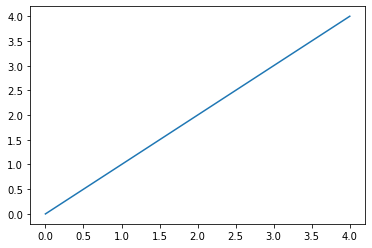

In [2]:
plt.plot(np.arange(5))

## Calcul forward pass

Dans cette première partie, nous allons créer les fonctions permettant d'effectuer le calcul forward pass d'un réseau de neurones.

### Fonctions d'activation

**Exercice** : Commençons par coder les fonctions d'activation que nous allons utiliser. Nous allons principalement nous concentrer sur les fonctions d'activation ReLU (pour les couches intermédiaires du réseau) et sigmoïde (pour la sortie, problème de classification).

En exercice, coder la fonction "activation" ci-dessous qui prend en argument un vecteur $Z$ une chaîne de caractère, soit "ReLU", soit "sigmoide" et qui renvoie le vecteur sur lequel est appliqué la fonction d'activation.

On rappelle :
- $ReLU(Z) = max(Z,0)$
- $sigmoide(Z) = \frac{1}{1 + e^{-Z}}$

Pour la sigmoïde, je vous conseille de privilégier l'utilisation de la tangente hyperbolique pour effectuer le calcul, cela peut éviter des problèmes numérique dans le calcul de l'exponentiel. La sigmoïde peut effectivement s'exprimer à l'aide dans la fonction tanh.

In [3]:
def activation(Z,fonction):
    
    if fonction == "ReLU":
        
        resultat = Z*(Z > 0)
    
    if fonction == "sigmoide":
        
        resultat = 1/2*(1+np.tanh(Z/2))
    
    return resultat

**Vérification** : Exécutez la cellule suivante

In [4]:
#NE PAS MODIFIER

Z = np.array([2.,10.,-5.,0.,-100.])

print(activation(Z,"ReLU"))
print(activation(Z,"sigmoide"))

[ 2. 10. -0.  0. -0.]
[0.88079708 0.9999546  0.00669285 0.5        0.        ]


### Calcul d'une couche de neurones

**Exercice** : On considère ici une couche de neurones, représentée par un vecteur $A$ (de $n \times N$ éléments représentant les $n$ neurones de la couche et $N$ représente le nombre d'exemples, car on peut avoir plusieurs exemples en même temps !). La couche suivante contiendra $m$ neurones, les poids reliant les deux couches seront représentés par une matrice $W$ de taille $m \times n$, et les biais par un vecteur de taille $m$.

Pour l'instant, on n'applique pas de fonction d'activation. On effectue le calcul linéaire : $Z = W.A + b$.

Vous devrez aussi renvoyer une variable "cache" qui contiendra simplement le triplet $(A,W,b,Z)$ qui vous avez en entrée. Cette variable peut paraître inutile à ce stade, mais elle sera en fait très utile dans le cadre de la backpropagation : souvenez-vous, il faut utiliser l'état de l'ensemble des couches du réseau pour effectuer le calcul de backpropagation.

**Hint** : Pour le calcul linéaire, la fonction np.dot devrait être utile.

In [5]:
def one_layer_linear(A,W,b):
    
    Z = np.dot(W,A) + b
    cache = (A,W,b,Z)
    
    return Z, cache

**Vérification** : Exécutez la cellule suivante :

In [6]:
#NE PAS MODIFIER

np.random.seed(seed = 1)

A = np.random.rand(3,2)
W = np.random.rand(4,3)
b = np.random.rand(4,1)

Z, cache = one_layer_linear(A,W,b)

print(Z)
print(cache == (A,W,b,Z))

[[0.27632903 0.41566595]
 [0.52340787 0.77623274]
 [0.89012538 1.21602897]
 [1.32990003 1.62896921]]
True


**Exercice** : Cette fois, on fait le calcul en entier, avec en plus la fonction d'activation. Notons $g$ la fonction d'activation, $A_{prev}$ le vecteur représentant la couche précédente, $A_{new}$ le résultat de la nouvelle couche, on a donc : $A_{new} = g(W.A_{prev} + b)$. La variable "fonction" contient une chaîne de caractère qui définit la fonction (soit "ReLU", soit "sigmoide" dans notre cas).

La variable cache devra contenir les mêmes quantités que précédemment.

**Hint** : Réutilisez les fonctions "activation" et "one_layer_linear" que vous avez codées précédemment.

In [7]:
def one_layer_activation(A_prev,W,b,fonction):
    
    Z, cache = one_layer_linear(A_prev,W,b)
    A_new = activation(Z,fonction)
        
    return A_new, cache

**Vérification** : Exécutez la cellule ci-dessous :

In [8]:
#NE PAS MODIFIER

np.random.seed(seed = 1)

A_prev = np.random.rand(3,2)
W = np.random.rand(4,3)
b = np.random.rand(4,1)

Z, cache_old = one_layer_linear(A_prev,W,b)

A_new, cache_new = one_layer_activation(A_prev,W,b,"sigmoide")
print(A_new)

[[0.56864601 0.60244568]
 [0.62794429 0.68486762]
 [0.70891605 0.77136397]
 [0.7908241  0.83602838]]


### Calcul du réseau de neurones entier

**Exercice** : Supposons que nous avons une liste de paramètres "List_W" et "List_b" qui contiennent l'ensemble des paramètres du réseau (poids et biais) pour chaque couche, ainsi qu'une entrée $X$ de taille $n_X \times N$, où $n_X$ est la dimension des inputs du réseau de neurones et $N$ est le nombre d'exemples.

"List_W" et "List_b" ont la même taille (le nombre de couches du réseau). On se donne aussi "List_activ" qui contient les fonctions d'activation à appliquer.

Codez la fonction ci-dessous qui applique le calcul feed_forward en entier, sur l'ensemble des couches.

La variable "caches" sera une liste qui contiendra l'ensemble des caches calculés à chaque couche du réseau. La variable Y_pred contiendra la sortie du réseau.

**Hints** :
- Cette fonction sera composée d'une boucle principale qui parcourera l'ensemble des couches du réseau.
- Réutilisez bien sûr la fonction "one_layer_activation" pour chaque couche.
- Pour connaître le nombre de couches, regardez la taille de l'une des listes de paramètres en entrée (np.size sera utile).
- Ajouter des éléments elem dans une liste l se fait en utilisant l.append(elem).

In [9]:
def feed_forward(X,list_W,list_b,list_activations):
    
    A = X
    N_couches = np.size(list_W)
    caches = []
    
    for i in range(N_couches):
    
        A_prev = A
        A, cache = one_layer_activation(A_prev,list_W[i],list_b[i],list_activations[i])
        caches.append(cache)
    
    Y_pred = A
    
    return Y_pred,caches

**Vérification** : Exécutez la cellule ci-dessous

In [10]:
#NE PAS MODIFIER

np.random.seed(seed = 2)

X = np.random.rand(5,3)
list_W = [np.random.rand(4,5)-1/2,np.random.rand(4,4)-1/2,np.random.rand(2,4)-1/2]
list_b = [np.random.rand(4,1)-1/2,np.random.rand(4,1)-1/2,np.random.rand(2,1)-1/2]
list_activations = ["ReLU","ReLU","sigmoide"]

Y_pred,caches = feed_forward(X,list_W,list_b,list_activations)

print(Y_pred)
print(len(caches) == 3)

[[0.3863283  0.38738737 0.38502977]
 [0.62732414 0.62279049 0.62796192]]
True


C:\Users\gd263782\Anaconda3\envs\keras_env\lib\site-packages\numpy\core\fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


## Loss function

Nous allons implémenter maintenant la loss function que nous allons utiliser. Ici, ce sera la binary_cross_entropy. Nous allons faire de la classification multi-classes non exclusives avec $K$ classes.

Nous redonnons la formule ci-dessous, pour un vecteur de prédictions $\hat{Y}$ composé de $N$ exemples $\hat{y_ik}$ qui doit être comparé à un vecteur de vraies valeurs $Y$ composé d'exemples $y_{ik}$ (l'indice $i$ représente l'exemple $i$ et l'indice $k$ représente la classe $k$):

\begin{equation}
L(Y,\hat{Y}) = - \frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} y_{ik} \log(\hat{y_{ik}}) + (1-y_{ik})\log(1-\hat{y_{ik}})
\end{equation}

**Exercice** : Codez la loss-function ci-dessous, où la variable Y_pred représente les prédictions.

**Hints** :
- Déterminez le nombre d'exemple à partir de la taille de Y (seconde dimension), la fonction shape sera utile
- Les fonctions np.sum et np.log seront utiles

In [11]:
def loss_function(Y,Y_pred):
    
    N = np.shape(Y)[1]
    
    loss = -1/N*np.sum(Y*np.log(Y_pred) + (1-Y)*np.log(1-Y_pred))
    
    return loss
    

**Vérification** : Exécutez la cellule ci-dessous

In [12]:
#NE PAS MODIFIER

np.random.seed(seed = 3)

Y = np.array([[1,0,1],[0,1,1]])
Y_pred = np.random.rand(2,3)

print(loss_function(Y,Y_pred))

1.3334702695881486


## Backward propagation

Dans cette partie, nous allons programmer la backpropagation de l'erreur, qui permettra de calculer les gradients et ainsi mettre à jour les paramètres du réseau de neurones.

### Backward linéraire

Considérons une couche $l$. On rappelle le calcul feed_forward : $Z^{[l]} = W^{[l]}.A^{[l-1]} + b^{[l]}$.

Supposons déjà connue la dérivée de la fonction de coût par rapport à $Z$ (de manière récursive) $\frac{\partial L}{\partial Z^{[l]}}$.

Nous allons calculer $\frac{\partial L}{\partial W^{[l]}}$, $\frac{\partial L}{\partial b^{[l]}}$ et $\frac{\partial L}{\partial A^{[l-1]}}$. Les deux premières permettent d'obtenir le gradient des paramètres de la couche $l$. La dernière dérivée sera utilisée pour la récursivité de la backpropagation.

On rappelle les formules (correspondant aux moyennes sur l'ensemble des exemples, d'où la présence des transposées et de la somme pour b) :

\begin{equation}
\frac{\partial L}{\partial W^{[l]}} = \frac{\partial L}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial W^{[l]}} = \frac{\partial L}{\partial Z^{[l]}} A^{[l-1]T}
\end{equation}

\begin{equation}
\frac{\partial L}{\partial b^{[l]}} = \sum_{i = 1}^{N} (\frac{\partial L}{\partial Z^{[l]}})_i 
\end{equation}

\begin{equation}
\frac{\partial L}{\partial A^{[l-1]}} = \frac{\partial L}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial A^{[l-1]}} = W^{[l]T}\frac{\partial L}{\partial Z^{[l]}} 
\end{equation}




**Exercice** : Codez ci-dessous ces trois formules dans la fonction "linear_backward". En entrée, on prend dZ, correspondant à la dérivée de Z supposée connue, et le cache qui contient (A_prev,W,b,Z), d'où l'utilité de ce cache que nous avions défini dans les fonctions feed_forward.

**Hint** : Pour la somme, bien faire attention à la dimension sur laquelle on l'applique (dimension correspondant aux exemples), à utiliser avec le mot-clé "axis = ...". Utilisez bien aussi le mot clé "keepdims = True" pour pouvoir maintenir les opérations valides au niveau de la dimension.

In [13]:
def linear_backward(dZ,cache):
    
    A_prev,W,b,Z = cache
    
    dW = np.dot(dZ,A_prev.T)
    db = np.sum(dZ,axis = 1,keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev,dW,db

**Vérification** : Exécutez la cellule ci-dessous

In [14]:
#NE PAS MODIFIER

np.random.seed(seed = 3)

dZ = np.random.rand(3,2)

A_pred = np.random.rand(4,2)
W = np.random.rand(3,4)
b = np.random.rand(3,1)
Z = np.random.rand(3,2)

cache =  (A_pred,W,b,Z)

print(linear_backward(dZ,cache))

(array([[0.84119935, 1.00609737],
       [0.58627548, 0.77106284],
       [0.58203064, 0.64998031],
       [1.20623246, 1.44921602]]), array([[0.21593072, 0.34050656, 0.33996121, 0.55475734],
       [0.14239875, 0.24014989, 0.24205415, 0.33109807],
       [0.29789138, 0.4410523 , 0.43613433, 0.82925743]]), array([[1.25894573],
       [0.80173234],
       [1.78924004]]))


### Ajoutons l'activation

**Exercice** : Dans un premier temps, nous allons calculer les dérivées des fonctions d'activation que nous avons utilisées.

Nous rappelons que :
- Pour $g = ReLU$, $g'(x) = 0$ si $x < 0$ et $g'(x) = 1$ si $x \ge 0$.
- Pour $g = sigmoide$, $g'(x) = g(x)(1-g(x))$

**Hints** : 
- Ne mettez pas de condition dans ReLU de type if, then ! Utilisez directement l'écriture booléenne $Z > 0$.
- Pour la sigmoïde, réutilisez la fonction activation que vous aviez codée au tout début

In [15]:
def derivate_activation(Z,activ):
    
    if activ == "ReLU":
        
        dg = (Z > 0)*1.
        
    if activ == "sigmoide":
        g = activation(Z,activ)
        dg = g*(1-g)
    
    return dg

**Vérification** : Exécutez la cellule suivante

In [16]:
#NE PAS MODIFIER

np.random.seed(seed = 4)

Z = np.random.rand(4,2) - 1/2

print(derivate_activation(Z,"ReLU"))
print(derivate_activation(Z,"sigmoide"))

[[1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 0.]]
[[0.23684838 0.24986062]
 [0.23653961 0.24713792]
 [0.24757229 0.24502909]
 [0.23634193 0.23536043]]


**Exercice** : On ajoute maintenant la dérivée de la fonction d'activation afin de calculer $\frac{\partial L}{\partial Z^{[l]}}$ à partir de $\frac{\partial L}{\partial A^{[l]}}$ (supposée connue par récursivité... vu qu'on la calcule avec la fonction précédente).

On rappelle la formule :

\begin{equation}
A^{[l]} = g(Z^{[l]})
\end{equation}

Ce qui donne donc :

\begin{equation}
\frac{\partial L}{\partial Z^{[l]}} = \frac{\partial L}{\partial A^{[l]}} \frac{\partial A^{[l]}}{\partial Z^{[l]}} = \frac{\partial L}{\partial A^{[l]}} g'(Z^{[l]})
\end{equation}

La fonction d'activation est donnée par activ.

**Hint** :
- La valeur de $Z^{[l]}$ sera utile, on rappelle qu'elle est justement dans le cache qui contient A_prev,W,b,Z
- Réutilisez les fonctions précédentes "linear_backward" pour retrouver les valeurs dA_prev, dW et db à partir du dZ que vous aurez calculé et derivate_activation pour avoir les dérivées des fonctions d'activation


In [17]:
def activation_backward(dA,cache,activ):
    
    A_prev,W,b,Z = cache
    
    dZ = dA*derivate_activation(Z,activ)
    
    dA_prev,dW,db = linear_backward(dZ,cache)
    
    return dA_prev,dW,db

**Vérification** : Exécutez la cellule ci-dessous

In [18]:
np.random.seed(seed = 3)

dA = np.random.rand(3,2)

A_pred = np.random.rand(4,2)
W = np.random.rand(3,4)
b = np.random.rand(3,1)
Z = np.random.rand(3,2)

cache =  (A_pred,W,b,Z)

print(activation_backward(dA,cache,"sigmoide"))

(array([[0.17487705, 0.217628  ],
       [0.12229471, 0.16062103],
       [0.12332169, 0.1508871 ],
       [0.25380512, 0.32009158]]), array([[0.04316761, 0.06778688, 0.06763646, 0.11153914],
       [0.02990346, 0.04956865, 0.04984338, 0.07145092],
       [0.06838174, 0.10498491, 0.10439884, 0.18202664]]), array([[0.25220214],
       [0.16993783],
       [0.40389105]]))


### Et on fait remonter le long du réseau

On part maintenant de la fin du réseau et on fait remonter le long des couches.

**Exercice** : Appliquez la backpropagation ci-dessous. 

**Hints** :
- Il faut dans un premier initialiser en calculant la dérivée de la loss function pour la dernière couche :
\begin{equation}
\frac{\partial L}{\partial A^{[N_{couches}]}} = \frac{\partial L}{\partial \hat{Y}^{[l]}} = - \frac{1}{N} (\frac{Y}{\hat{Y}} - \frac{1 - Y}{1 - \hat{Y}}) 
\end{equation}

- On fait ensuite une boucle en remontant le sens des couches (notez l'utilisation de reversed(range(Ncouches))

- Utilisez les caches qui sont stockés sous forme de liste

- Stockez enfin les gradients des paramètres dans deux listes list_dW et list_db : attention de les insérez à chaque fois au début de la liste itérativement (et non à la fin) car on remonte les couches dans la backpropagation ! La fonction l.insert(0,var) sera utile pour cela, où l est la liste, 0 est la position (au début de la liste) et var est la variable à insérer.

In [19]:
def backward_propagation(Y_pred,Y,caches,activations):
    
    list_dW = []
    list_db = []
    
    N_couches = len(caches)
    N = np.shape(Y)[1]
    Y = Y.reshape(np.shape(Y_pred))
    
    dA_cur = -1/N*(Y/Y_pred - (1-Y)/(1-Y_pred))
    
    for l in reversed(range(N_couches)):
        cache = caches[l]
        activ = activations[l]
        dA_prev,dW,db = activation_backward(dA_cur,cache,activ)
        
        list_dW.insert(0,dW)
        list_db.insert(0,db)
        
        dA_cur = dA_prev
    
    return list_dW, list_db      

In [20]:
#NE PAS MODIFIER

np.random.seed(seed = 2)

X = np.random.rand(5,3)
list_W = [np.random.rand(4,5)-1/2,np.random.rand(4,4)-1/2,np.random.rand(2,4)-1/2]
list_b = [np.random.rand(4,1)-1/2,np.random.rand(4,1)-1/2,np.random.rand(2,1)-1/2]
list_activations = ["ReLU","ReLU","sigmoide"]

Y_pred,caches = feed_forward(X,list_W,list_b,list_activations)

Y = np.array([[0,1,1],[1,0,1]])

print(backward_propagation(Y_pred,Y,caches,list_activations))

([array([[-0.00677534,  0.00447579,  0.01418342,  0.01319047,  0.01236515],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.01243833,  0.00607596,  0.0040221 ,  0.00898123,  0.00190816]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.04529126,  0.        ,  0.        ,  0.00732433],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.01746327,  0.        ,  0.        ,  0.00810363]]), array([[ 0.        , -0.00673947,  0.        , -0.01793444],
       [ 0.        , -0.00458954,  0.        , -0.01426107]])], [array([[0.01130477],
       [0.        ],
       [0.        ],
       [0.01887614]]), array([[0.        ],
       [0.04775503],
       [0.        ],
       [0.00621147]]), array([[-0.28041819],
       [-0.04064115]])])


## Mise à jour des paramètres

**Exercice** : Une fois les gradients des paramètres calculés, il suffit de mettre à jour les anciens paramètres et les remplacer par les nouveaux. Codez la fonction qui prend la liste des anciens paramètres (list_w,list_b), la liste des gradients (list_dw,list_db) et le taux d'apprentissage alpha, pour renvoyer la liste des nouveaux paramètres suivant la formule de mise à jour du gradient :

\begin{equation}
W^{[l]} := W^{[l]} - \alpha \frac{\partial L}{\partial W^{[l]}}
\end{equation}

\begin{equation}
b^{[l]} := b^{[l]} - \alpha \frac{\partial L}{\partial b^{[l]}}
\end{equation}



In [21]:
def update_parameters(list_w,list_b,list_dw,list_db,alpha):
    
    N_couches = len(list_w)
    
    for l in range(N_couches):
        
        list_w[l] = list_w[l] - alpha*list_dw[l]
        list_b[l] = list_b[l] - alpha*list_db[l]
    
    return list_w,list_b

**Vérification** : Exécutez la cellule ci-dessous

In [22]:
#NE PAS MODIFIER

np.random.seed(seed = 2)

X = np.random.rand(5,3)
list_W = [np.random.rand(4,5)-1/2,np.random.rand(4,4)-1/2,np.random.rand(2,4)-1/2]
list_b = [np.random.rand(4,1)-1/2,np.random.rand(4,1)-1/2,np.random.rand(2,1)-1/2]
list_activations = ["ReLU","ReLU","sigmoide"]

Y_pred,caches = feed_forward(X,list_W,list_b,list_activations)

Y = np.array([[0,1,1],[1,0,1]])

list_dw, list_db = backward_propagation(Y_pred,Y,caches,list_activations)

print(update_parameters(list_W,list_b,list_dw,list_db,0.01))

([array([[ 0.2854029 ,  0.35393053, -0.005905  ,  0.34642958, -0.42047817],
       [ 0.00524609, -0.4347135 , -0.07187767, -0.40346908, -0.37284003],
       [ 0.09674531, -0.273988  , -0.39305432, -0.27969379, -0.15017371],
       [-0.0323369 , -0.29831753,  0.1403665 , -0.01701998,  0.00521764]]), array([[-1.13107349e-01,  2.93637454e-01,  8.00041789e-02,
        -3.37701401e-01],
       [ 2.00299434e-01,  4.64551080e-01,  8.36117022e-06,
         3.89446821e-01],
       [-1.58386347e-01,  6.71441276e-02, -7.24540367e-02,
        -6.32527370e-02],
       [ 2.76733818e-01,  3.56041735e-02,  4.53742227e-01,
         4.41271238e-02]]), array([[-0.41790508, -0.1335902 ,  0.3508505 , -0.09354561],
       [-0.47279763, -0.25277687, -0.43285563,  0.49399462]])], [array([[0.47046727],
       [0.30025835],
       [0.10181712],
       [0.2647711 ]]), array([[-0.33077455],
       [-0.20745432],
       [ 0.02406688],
       [-0.14343783]]), array([[-0.45151685],
       [ 0.48355986]])])


## Initialisation des paramètres

Il nous manque une étape essentielle : l'initialisation des paramètres. Nous allons faire une initialisation aléatoire des paramètres, suivant une loi normale centrée réduite.

**Exercice** : On se donne une structure de réseau de neurones : une liste contenant le nombre de neurones de chaque couche. Le premier élément de la liste est la taille de la donnée d'entrée, les éléments suivant sont le nombre de neurones de chaque couche.

Votre exercice est de fournir une liste initiale de matrices aléatoires de poids W et b, tirés suivant une loi normale centrée réduite, avec les bonnes dimensions. La liste list_neurons contient le nombre de neurones de chaque couche et le premier élément est la dimension des données d'entrée.

Nous rappelons que les matrices des poids sont de forme (nombre de neurones couche l + 1, nombre de neurones couche l). Les vecteurs de biais sont de formes (nombre de neurones couche l). Notons qu'il n'est pas nécessaire d'initialiser aléatoirement les vecteurs de biais. Nous allons ici ne mettre que des zéros.

**Hint** :
- Les fonctions np.random.randn et np.zeros seront utiles


In [23]:
def initialisation_parameters(list_neurons):
    
    N_couches = len(list_neurons)
    
    list_W = []
    list_b = []
    
    for l in range(N_couches - 1):
        
        list_W.append(np.random.randn(list_neurons[l+1],list_neurons[l]))
        list_b.append(np.zeros((list_neurons[l+1],1)))
    
    return list_W, list_b

**Vérification** : Exécutez la cellule suivante

In [24]:
#NE PAS MODIFIER

list_neurons = [2,3,3,1]

np.random.seed(seed = 2)

print(initialisation_parameters(list_neurons))

([array([[-0.41675785, -0.05626683],
       [-2.1361961 ,  1.64027081],
       [-1.79343559, -0.84174737]]), array([[ 0.50288142, -1.24528809, -1.05795222],
       [-0.90900761,  0.55145404,  2.29220801],
       [ 0.04153939, -1.11792545,  0.53905832]]), array([[-0.5961597 , -0.0191305 ,  1.17500122]])], [array([[0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.]]), array([[0.]])])


## Et c'est parti pour l'entraînement

Nous allons nous intéresser au problème du XOR (ou exclusif). Prenons des vecteurs à deux dimensions. Si les deux coordonnées ont le même signe, on dira que le vecteur appartient à la classe 1, et 0 si les deux coordonnées sont de signes opposés. En exercice, vous pouvez faire un dessin représentant la situation. On comprend ici qu'un séparateur linéaire ne permettra pas de séparer les deux classes. Nous allons faire un réseau de neurones pour cela. Ci-dessous, je vous construis une base de données.

In [25]:
#NE PAS MODIFIER

N_train = 200

X_train = 2*np.random.rand(2,N_train) - 1

Y_train = (np.sign(X_train[0,:]) == np.sign(X_train[1,:]))*1

Y_train = np.reshape(Y_train,(1,N_train))

N_test = 100

X_test = 2*np.random.rand(2,N_test) - 1

Y_test = (np.sign(X_test[0,:]) == np.sign(X_test[1,:]))*1

Y_test = np.reshape(Y_test,(1,N_test))

**Exercice** : Initialiser les paramètres d'un réseau d'architecture suivante : [2,5,5,1]. L'entrée est en effet de dimension 2 et la sortie de dimension 1. Donnez aussi les fonctions d'activation pour l'ensemble des couches intermédiaires et sigmoïde pour la dernière sortie (attention, il n'y a que 3 couches).

In [26]:
list_neurons = [2,5,5,1]

list_activations = ["ReLU","ReLU","sigmoide"]

list_W,list_b = initialisation_parameters(list_neurons)

**Exercice** : Effectuez un millier d'époques d'apprentissage avec un taux d'apprentissage de 0.1. A chaque itération, affichez la valeur de la loss function sur la base de test et la base d'apprentissage. Utilisez les fonctions que vous avez définies ci-dessus.

**Hint** :
- A chaque époque, effectuez une propagation forward pass
- Calculez la loss function que vous obtenez et affichez-la (base d'entraînement et base de test)
- Effectuez la back-propagation pour calculer les listes de gradients
- Mettez à jour les paramètres
- Et on boucle !

In [27]:
N_epoques = 1000

alpha = 0.1

for i in range(N_epoques):
    
    Y_pred_train, caches = feed_forward(X_train,list_W,list_b,list_activations)
    
    Y_pred_test, _ = feed_forward(X_test,list_W,list_b,list_activations)
    
    loss_train = loss_function(Y_train,Y_pred_train)
    
    loss_test = loss_function(Y_test,Y_pred_test)
    
    print("Epoque" + str(i))
    print("Training loss: " + str(loss_train))
    print("Test loss: " + str(loss_test))
    
    list_dW, list_db = backward_propagation(Y_pred_train,Y_train,caches,list_activations)
    
    list_W,list_b = update_parameters(list_W,list_b,list_dW,list_db,alpha)

Epoque0
Training loss: 0.8364543808009125
Test loss: 0.8164209430537517
Epoque1
Training loss: 0.813196356584986
Test loss: 0.7985169357472199
Epoque2
Training loss: 0.7935132169124293
Test loss: 0.7837587803901106
Epoque3
Training loss: 0.7769186307136235
Test loss: 0.7713405572378211
Epoque4
Training loss: 0.7629508396809468
Test loss: 0.7610301112011502
Epoque5
Training loss: 0.7509758619526312
Test loss: 0.752254412553438
Epoque6
Training loss: 0.7404727096462588
Test loss: 0.7446398698942922
Epoque7
Training loss: 0.7313078584944627
Test loss: 0.7379451899021351
Epoque8
Training loss: 0.7232412369398035
Test loss: 0.7320913377901357
Epoque9
Training loss: 0.7160278192100582
Test loss: 0.7269355121557584
Epoque10
Training loss: 0.7095474495622729
Test loss: 0.7223521135222669
Epoque11
Training loss: 0.7036332574364719
Test loss: 0.718203750007133
Epoque12
Training loss: 0.6981925615189826
Test loss: 0.7144280322881348
Epoque13
Training loss: 0.6931269355331173
Test loss: 0.71099886

Epoque122
Training loss: 0.28173112925894683
Test loss: 0.3468956583191021
Epoque123
Training loss: 0.27897391915537345
Test loss: 0.3435178501549314
Epoque124
Training loss: 0.2762615321740358
Test loss: 0.3401823875995118
Epoque125
Training loss: 0.2735970618256024
Test loss: 0.3368899676094897
Epoque126
Training loss: 0.27099172308298886
Test loss: 0.333645822452102
Epoque127
Training loss: 0.26846592752504755
Test loss: 0.3305127370048382
Epoque128
Training loss: 0.2659805159780401
Test loss: 0.32741783217913173
Epoque129
Training loss: 0.2635388698036265
Test loss: 0.3243683560709112
Epoque130
Training loss: 0.26115102438286586
Test loss: 0.3213743861245768
Epoque131
Training loss: 0.2588180289808605
Test loss: 0.31847859084085434
Epoque132
Training loss: 0.25653503819231416
Test loss: 0.3156221448193124
Epoque133
Training loss: 0.2543088364912396
Test loss: 0.312835967731495
Epoque134
Training loss: 0.25212186045443424
Test loss: 0.31008990747238385
Epoque135
Training loss: 0.249

Epoque249
Training loss: 0.13937548420064985
Test loss: 0.15679280685502295
Epoque250
Training loss: 0.13893745508052235
Test loss: 0.15618273287222578
Epoque251
Training loss: 0.13850322843964016
Test loss: 0.15557729247687657
Epoque252
Training loss: 0.13807273879817777
Test loss: 0.15497747678340054
Epoque253
Training loss: 0.13764593106194645
Test loss: 0.15438207582998525
Epoque254
Training loss: 0.1372227512110327
Test loss: 0.15379105683671157
Epoque255
Training loss: 0.13680314627328385
Test loss: 0.15320439813851952
Epoque256
Training loss: 0.13638706429929454
Test loss: 0.15262204098521268
Epoque257
Training loss: 0.1359744543385659
Test loss: 0.15204394757798212
Epoque258
Training loss: 0.1355652664166202
Test loss: 0.15147007778640073
Epoque259
Training loss: 0.13515945151292566
Test loss: 0.15090038957961796
Epoque260
Training loss: 0.13475696153953115
Test loss: 0.1503348419841328
Epoque261
Training loss: 0.13435774932033798
Test loss: 0.14977339459757813
Epoque262
Traini

Epoque394
Training loss: 0.09976688540282029
Test loss: 0.09876582778519201
Epoque395
Training loss: 0.0995916826670447
Test loss: 0.09851181160278515
Epoque396
Training loss: 0.09941726623653115
Test loss: 0.09825896128517442
Epoque397
Training loss: 0.09924363005692825
Test loss: 0.09800726844202612
Epoque398
Training loss: 0.09907076815897874
Test loss: 0.09775672478816906
Epoque399
Training loss: 0.09889867464798037
Test loss: 0.09750732127585042
Epoque400
Training loss: 0.09872734377671936
Test loss: 0.09725905074123588
Epoque401
Training loss: 0.09855676993922961
Test loss: 0.09701189852448257
Epoque402
Training loss: 0.09838694705048574
Test loss: 0.09676586384790639
Epoque403
Training loss: 0.09821786944408636
Test loss: 0.096520938928533
Epoque404
Training loss: 0.09804953151500642
Test loss: 0.09627711605176117
Epoque405
Training loss: 0.09788192771870372
Test loss: 0.09603438757796313
Epoque406
Training loss: 0.09771505257024309
Test loss: 0.09579274594638428
Epoque407
Train

Epoque521
Training loss: 0.08238581013680438
Test loss: 0.07402281197862214
Epoque522
Training loss: 0.0822780384211943
Test loss: 0.07385050158625608
Epoque523
Training loss: 0.08217120572162084
Test loss: 0.07368160980552436
Epoque524
Training loss: 0.08206531375105797
Test loss: 0.07357853251609686
Epoque525
Training loss: 0.08195878661132926
Test loss: 0.07340624832719544
Epoque526
Training loss: 0.08185278196798891
Test loss: 0.07323777143136667
Epoque527
Training loss: 0.0817482420703566
Test loss: 0.07313690160170844
Epoque528
Training loss: 0.08164273878253102
Test loss: 0.07296655382502244
Epoque529
Training loss: 0.08153761059729928
Test loss: 0.07279989246885885
Epoque530
Training loss: 0.08143395306575708
Test loss: 0.07263646179284372
Epoque531
Training loss: 0.08132976472913678
Test loss: 0.07254261473659003
Epoque532
Training loss: 0.08122561782577076
Test loss: 0.0723753521093926
Epoque533
Training loss: 0.08112243732063451
Test loss: 0.07221153178286017
Epoque534
Train

Test loss: 0.05866750063562598
Epoque646
Training loss: 0.07115494717631156
Test loss: 0.05861992535420432
Epoque647
Training loss: 0.0710784725530343
Test loss: 0.05849019447583124
Epoque648
Training loss: 0.07100412123442743
Test loss: 0.058438270997108736
Epoque649
Training loss: 0.07092797267699066
Test loss: 0.0583069747485819
Epoque650
Training loss: 0.07085285247603348
Test loss: 0.05818012565431703
Epoque651
Training loss: 0.0707783672757084
Test loss: 0.05813304276508057
Epoque652
Training loss: 0.07070279239916477
Test loss: 0.05800388817169183
Epoque653
Training loss: 0.07062870767554336
Test loss: 0.05787899787677426
Epoque654
Training loss: 0.07055429876217219
Test loss: 0.05783367420153918
Epoque655
Training loss: 0.07047929811555134
Test loss: 0.05770618714950856
Epoque656
Training loss: 0.07040603005320543
Test loss: 0.05758512569887285
Epoque657
Training loss: 0.07033196396993442
Test loss: 0.05754105284446465
Epoque658
Training loss: 0.07025749908003633
Test loss: 0.0

Epoque821
Training loss: 0.06027622918878834
Test loss: 0.0452840488320546
Epoque822
Training loss: 0.060225595318884315
Test loss: 0.04531663408727374
Epoque823
Training loss: 0.06017503241999526
Test loss: 0.045195546491521535
Epoque824
Training loss: 0.06012429511273387
Test loss: 0.04514856216215869
Epoque825
Training loss: 0.06007373780743181
Test loss: 0.04510000394058265
Epoque826
Training loss: 0.06002333353727989
Test loss: 0.04505004850491413
Epoque827
Training loss: 0.059973441006983014
Test loss: 0.04499553675670076
Epoque828
Training loss: 0.05992354764331906
Test loss: 0.04487851177527472
Epoque829
Training loss: 0.05987332698857129
Test loss: 0.044835034939672815
Epoque830
Training loss: 0.05982327008688457
Test loss: 0.044789513657677256
Epoque831
Training loss: 0.05977339349542527
Test loss: 0.04474222955309503
Epoque832
Training loss: 0.05972647707130243
Test loss: 0.044769939665976644
Epoque833
Training loss: 0.05967464694492598
Test loss: 0.04464418054984567
Epoque8

Epoque946
Training loss: 0.054642509033262156
Test loss: 0.03896322869981976
Epoque947
Training loss: 0.054602141854335574
Test loss: 0.038917873328413954
Epoque948
Training loss: 0.05456186249623582
Test loss: 0.038872822224223
Epoque949
Training loss: 0.05452372541216091
Test loss: 0.03876435782116158
Epoque950
Training loss: 0.05448228993170498
Test loss: 0.03880499138295898
Epoque951
Training loss: 0.054442179700754
Test loss: 0.03875734903430485
Epoque952
Training loss: 0.05440227497143669
Test loss: 0.03871048656567252
Epoque953
Training loss: 0.054362626079359336
Test loss: 0.03860051709072801
Epoque954
Training loss: 0.05432276362135895
Test loss: 0.03856350173289832
Epoque955
Training loss: 0.05428342785002673
Test loss: 0.038602284450079696
Epoque956
Training loss: 0.05424390742916238
Test loss: 0.03848912127411631
Epoque957
Training loss: 0.05420410456862314
Test loss: 0.03844962972620358
Epoque958
Training loss: 0.054164427854080925
Test loss: 0.038409762352969515
Epoque959

Les loss functions devraient décroître si votre apprentissage se passent bien. Ci dessous, vous trouverez la précision sur le jeu de test, ainsi que sur le jeu d'entraînement : on se fixe un seuil de 0.5, si la prédiction est supérieure à 0.5, on l'associe à la classe 1, et à la classe 0 sinon. On compte le nombre de fois où la classe prédite est égale à la classe attendue et on regarde par rapport au nombre d'exemples.

In [28]:
print("Accuracy sur le jeu de test : " + str(np.sum((Y_pred_test > 0.5) == Y_test)/N_test))

Accuracy sur le jeu de test : 1.0


In [29]:
print("Accuracy sur le jeu d'entraînement : " + str(np.sum((Y_pred_train > 0.5) == Y_train)/N_train))

Accuracy sur le jeu d'entraînement : 0.99


Ci-dessous pour visualiser vos prédictions sur l'ensemble du carré unité en deux dimensions !

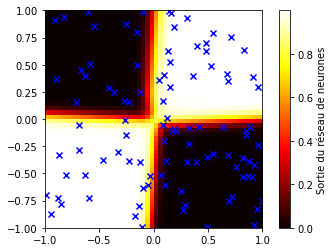

In [30]:
grid = np.meshgrid(np.linspace(-1.,1.,50),np.linspace(-1,1,50))

X_test_new = np.array([grid[0].flatten(),grid[1].flatten()])

Y_pred_new, _ = feed_forward(X_test_new,list_W,list_b,list_activations)

maps = plt.imshow((Y_pred_new.reshape(grid[0].shape[0],grid[0].shape[1])),extent = (-1,1,-1,1),cmap = "hot",origin = "lower")
plt.scatter(X_test[0,:],X_test[1,:],color = "blue",marker = "x")
plt.colorbar(maps, label = "Sortie du réseau de neurones")